In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
import os
import pandas as pd
import numpy as np
import cv2

In [2]:
base_dir = r'E:\AB\UEM\year 3\SEM 6\pneumonia_binary\train'
img_h,img_w= (164,164)
batch_size=8
#epochs=3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen= ImageDataGenerator(horizontal_flip=True, vertical_flip=True,width_shift_range=0.2, height_shift_range=0.2,rescale=1./255,validation_split=0.2)

In [3]:
import keras
from keras.applications.mobilenet import MobileNet
from keras.models import Model,load_model,Sequential
from keras.layers import Input,Activation, Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.callbacks import EarlyStopping, History
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import PReLU
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.callbacks import ReduceLROnPlateau

import keras
from tensorflow.python.keras.metrics import Metric

base_model = MobileNet(input_shape=(164,164,3), include_top=False,weights='imagenet')

for layer in base_model.layers[:-7]:
    layer.trainable=False

 
model=Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))


model.add(Dense(2,activation='sigmoid'))
#model.add(Dense(1))
#model.add(Activation("sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 5, 5, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 25600)             0         
                                                                 
 dropout (Dropout)           (None, 25600)             0         
                                                                 
 dense (Dense)               (None, 2)                 51202     
                                                                 
Total params: 3,280,066
Trainable params: 1,113,090
Non-trainable params: 2,166,976
_________________________________________________________________


In [4]:
from tensorflow.keras.callbacks import ReduceLROnPlateau


reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.1,
                                         patience=3,
                                         cooldown=2,
                                         min_lr=1e-10,
                                         verbose=1)

checkpoint =tf.keras.callbacks.ModelCheckpoint(filepath="mobilenet.h5", 
                            monitor='val_accuracy',
                            verbose=1,
                            save_best_only=True, 
                            save_weights_only=False, 
                            mode='auto',
                            save_freq='epoch')


import time
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

callbacks = [reduce_learning_rate, checkpoint, time_callback]
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile( loss='binary_crossentropy',optimizer= optimizer, metrics=['accuracy',keras.metrics.Precision(),keras.metrics.Recall()])

F:\Anaconda\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [15]:
val_dir = r'E:\AB\UEM\year 3\SEM 6\pneumonia_binary\val'

base_dn = r'E:\AB\UEM\year 3\SEM 6\chest_xray\train'
val_dn = r'E:\AB\UEM\year 3\SEM 6\chest_xray\val'
train_generator = datagen.flow_from_directory(
        base_dn,  # This is the source directory for training images
        target_size=(img_h,img_w),  
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        #color_mode="rgb",
        shuffle=True)


validation_generator = datagen.flow_from_directory(
        val_dn,     
        target_size=(img_h, img_w),
        batch_size=batch_size,
        class_mode='categorical',
        #color_mode="rgb",
        subset='validation',
        shuffle=False)

Found 4173 images belonging to 2 classes.
Found 2 images belonging to 2 classes.


In [ ]:
'''X_train, X_test, y_train, y_test = train_test_split(train, test,
    test_size=0.2, shuffle = True, random_state = 8)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
    test_size=0.25, random_state= 8)'''

In [16]:
#es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples//batch_size, 
      epochs=5,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples//batch_size,  
      callbacks=callbacks,
      verbose=1)


Epoch 1/5
521/521 [==============================] - 169s 325ms/step - loss: 0.7722 - accuracy: 0.9402 - precision: 0.9381 - recall: 0.9383 - lr: 0.0010
Epoch 2/5
521/521 [==============================] - 259s 498ms/step - loss: 0.7932 - accuracy: 0.9445 - precision: 0.9438 - recall: 0.9443 - lr: 0.0010
Epoch 3/5
521/521 [==============================] - 321s 616ms/step - loss: 0.7315 - accuracy: 0.9465 - precision: 0.9431 - recall: 0.9436 - lr: 0.0010
Epoch 4/5
521/521 [==============================] - 290s 556ms/step - loss: 0.7372 - accuracy: 0.9496 - precision: 0.9486 - recall: 0.9491 - lr: 0.0010
Epoch 5/5
521/521 [==============================] - 174s 333ms/step - loss: 0.7582 - accuracy: 0.9561 - precision: 0.9537 - recall: 0.9546 - lr: 0.0010


In [17]:
model.evaluate(validation_generator,verbose=1)

1/1 [==============================] - 0s 266ms/step - loss: 2.0923 - accuracy: 0.5000 - precision: 0.6667 - recall: 1.0000


[2.092266082763672, 0.5, 0.6666666865348816, 1.0]

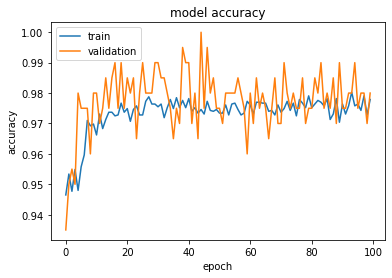

In [16]:
from matplotlib import pyplot as plt 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

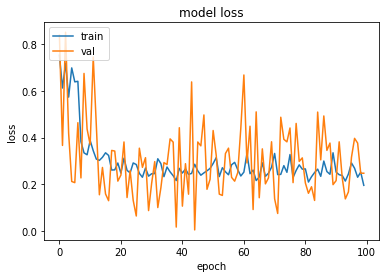

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
accu= history.history['val_accuracy']
print(max(accu),"at epoch number-",accu.index(max(accu))+1)

0.9750000238418579 at epoch number- 1


In [18]:
img = cv2.imread("E:\\AB\\UEM\\year 3\\SEM 6\\pneumonia_binary\\train\\opacity\\person434_virus_883.jpeg") 
image_resized= cv2.resize(img, (img_h,img_w))
'''cv2.imshow('CT scan', img)
cv2.waitKey(0)
E:\\AB\\UEM\\year 3\\SEM 6\\pneumonia_binary\\val\\normal\\NORMAL2-IM-1261-0001.jpeg
E:\\AB\\UEM\\year 3\\SEM 6\\pneumonia_binary\\test\\opacity\\person17_virus_48.jpeg
E:\\AB\\UEM\\year 3\\SEM 6\\pneumonia_binary\\val\\normal\\NORMAL2-IM-1102-0001-0002.jpeg
E:\\AB\\UEM\\year 3\\SEM 6\\pneumonia_binary\\val\\opacity\\person1453_bacteria_3771.jpeg
E:\\AB\\UEM\\year 3\\SEM 6\\pneumonia_binary\\test\\opacity\\person47_virus_99.jpeg
E:\\AB\\UEM\\year 3\\SEM 6\\pneumonia_binary\\val\\opacity\\person1454_bacteria_3778.jpeg
E:\\AB\\UEM\\year 3\\SEM 6\\pneumonia_binary\\val\\opacity\\person1449_bacteria_3743.jpeg
E:\\AB\\UEM\\year 3\\SEM 6\\pneumonia_binary\\train\\opacity\\person28_bacteria_142.jpeg
E:\\AB\\UEM\\year 3\\SEM 6\\pneumonia_binary\\train\\opacity\\person434_virus_883.jpeg
'''
img=np.expand_dims(image_resized,axis=0)
np.set_printoptions(suppress=True)
pred=model.predict(img)
#print(pred);
yn=np.argmax(pred,axis=1)
if yn==0:
    print("Pneumonia")
else :
    print("Not")

Not


In [12]:
pred

array([[0., 1.]], dtype=float32)

In [13]:
model2= tf.keras.models.load_model("mobilenet.h5")
y_pred= model2.predict(validation_generator,verbose=1)
y_true= validation_generator.classes
y_pred2= np.argmax(y_pred,axis=1)

from sklearn.metrics import confusion_matrix

cf=confusion_matrix(y_true, y_pred2)
cf

26/26 [==============================] - 10s 361ms/step


array([[ 46,   7],
       [  1, 153]], dtype=int64)